In [2]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter

from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

from time import time
import seaborn as sb

In [1]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [14]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

cat_to_name['95']

'bougainvillea'

In [19]:
def load_checkpoint(filepath):
    
    model = models.vgg16(pretrained = True)
                         
    for param in model.parameters():
        param.requires_grad = False
    
    model.classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(1024, 512)),
                          ('relu2', nn.ReLU()),
                          ('dropout2', nn.Dropout(0.2)),
                          ('fc3', nn.Linear(512, 256)),
                          ('relu3', nn.ReLU()),
                          ('dropout3', nn.Dropout(0.2)),
                          ('output_fc', nn.Linear(256, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    epochs = checkpoint['epochs']
    learning_rate = checkpoint['learning_rate']

    model.class_to_idx = checkpoint['class_to_idx'] 
    
    return model, epochs, learning_rate

model, epochs, learning_rate = load_checkpoint('Final_checkpoint/checkpoint.pth')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

In [16]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    img = Image.open(image) 
    transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    img = np.array(transform(img))

    return img

In [6]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array(image).transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [20]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    image = torch.from_numpy(image).type(torch.FloatTensor)
    image = image.unsqueeze(0) 
    image = image.to(device)
    
    model.eval()
    
    with torch.no_grad ():
        output = model.forward(image)
        
    output_prob = torch.exp(output)
    
    probs, indeces = output_prob.topk(topk)
    probs   =   probs.to('cpu').numpy().tolist()[0]
    indeces = indeces.to('cpu').numpy().tolist()[0]
    
    mapping = {val: key for key, val in model.class_to_idx.items()}
    classes = [mapping[item] for item in indeces]
    
    return probs, classes

[0.826769232749939, 0.050712160766124725, 0.037127770483493805, 0.0365646667778492, 0.009747774340212345]
['24', '73', '93', '92', '61']
['red ginger', 'water lily', 'ball moss', 'bee balm', 'cautleya spicata']


E:\Softwares\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


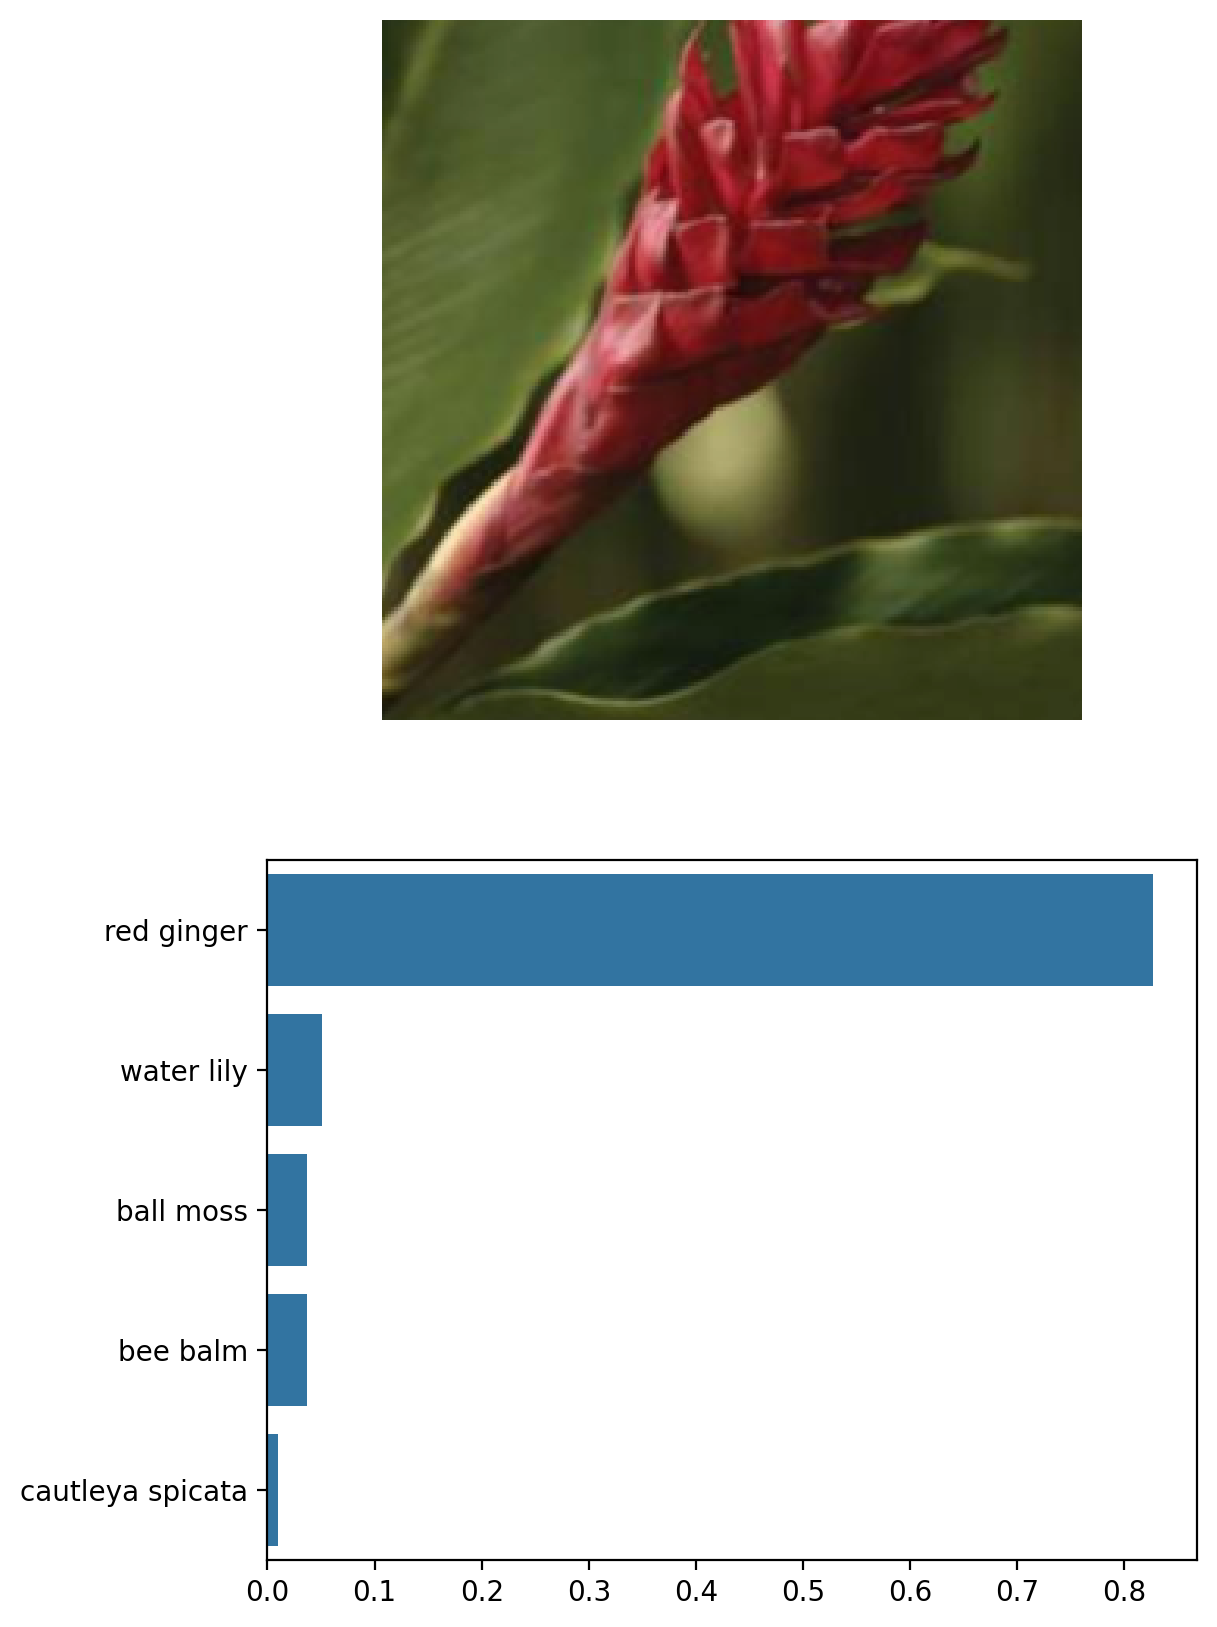

In [21]:
image_path = 'flowers/test/24/image_06815.jpg'

probs, classes = predict(image_path, model, 5)

names = [cat_to_name[key] for key in classes]

print(probs)
print(classes)
print(names)

plt.figure(figsize = (6,10))

ax    = plt.subplot(2,1,1)
image = process_image(image_path)
ax    = imshow(image, ax=ax, title=names[0])
ax.axis('off')

plt.subplot(2,1,2)
sb.barplot(x=probs, y=names, color=sb.color_palette()[0]);

plt.show()